**To run this notebook, it's necessary to install** `tqdm` **package. (hyperopt and hyperas have been commented)**

** I commented all codes that would take long time to run.**

# Basic processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib

In [2]:
data = pd.read_csv("./data/final_project_data.csv")
data = data.dropna()
data.index = range(len(data))

In [5]:
# downcast data to save memory
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

data = downcast_dtypes(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547259 entries, 0 to 3547258
Data columns (total 43 columns):
date                           int32
id                             object
industry                       int32
ret_raw                        float32
flag                           bool
ret_20_raw                     float32
flag2                          bool
ret_raw_norm                   float32
ret_20_raw_norm                float32
ret_raw_norm_lag_21            float32
ret_raw_norm_lag_22            float32
ret_raw_norm_lag_23            float32
ret_raw_norm_lag_24            float32
ret_raw_norm_lag_25            float32
ret_raw_norm_lag_26            float32
ret_raw_norm_lag_27            float32
ret_raw_norm_lag_28            float32
ret_raw_norm_lag_29            float32
ret_raw_norm_lag_30            float32
ret_raw_norm_lag_31            float32
ret_raw_norm_lag_32            float32
ret_raw_norm_lag_33            float32
ret_raw_norm_lag_34            float32
r

In [7]:
data.columns

Index(['date', 'id', 'industry', 'ret_raw', 'flag', 'ret_20_raw', 'flag2',
       'ret_raw_norm', 'ret_20_raw_norm', 'ret_raw_norm_lag_21',
       'ret_raw_norm_lag_22', 'ret_raw_norm_lag_23', 'ret_raw_norm_lag_24',
       'ret_raw_norm_lag_25', 'ret_raw_norm_lag_26', 'ret_raw_norm_lag_27',
       'ret_raw_norm_lag_28', 'ret_raw_norm_lag_29', 'ret_raw_norm_lag_30',
       'ret_raw_norm_lag_31', 'ret_raw_norm_lag_32', 'ret_raw_norm_lag_33',
       'ret_raw_norm_lag_34', 'ret_raw_norm_lag_35', 'ret_raw_norm_lag_36',
       'ret_raw_norm_lag_37', 'ret_raw_norm_lag_38', 'ret_raw_norm_lag_39',
       'ret_raw_norm_lag_40', 'ret_20_raw_norm_lag_41_60',
       'ret_20_raw_norm_lag_61_80', 'ret_20_raw_norm_lag_81_100',
       'ret_20_raw_norm_lag_101_120', 'ret_20_raw_norm_lag_121_140',
       'ret_20_raw_norm_lag_141_160', 'ret_20_raw_norm_lag_161_180',
       'ret_20_raw_norm_lag_181_200', 'ret_20_raw_norm_lag_201_220',
       'ret_20_raw_norm_lag_221_240', 'ret_20_raw_norm_lag_241_260',
   

In [8]:
data.head()

,date,id,industry,ret_raw,flag,ret_20_raw,flag2,ret_raw_norm,ret_20_raw_norm,ret_raw_norm_lag_21,...,ret_20_raw_norm_lag_121_140,ret_20_raw_norm_lag_141_160,ret_20_raw_norm_lag_161_180,ret_20_raw_norm_lag_181_200,ret_20_raw_norm_lag_201_220,ret_20_raw_norm_lag_221_240,ret_20_raw_norm_lag_241_260,ret_20_raw_norm_lag_261_280,isJan,target
0,20080214,A US Equity,3520,-0.034888,True,-0.115785,False,-0.626602,-1.155291,-0.342618,...,-0.927360,0.184879,0.157539,1.093994,-0.189996,0.915039,-0.259174,-1.240792,0.0,0.0
1,20080214,AA US Equity,1510,-0.004224,True,0.160461,False,0.538586,1.116039,-0.616964,...,-0.811019,0.657379,-0.466201,1.449841,0.170922,0.042121,0.339868,1.037797,0.0,1.0
2,20080214,AAN US Equity,2550,0.000000,True,0.102639,False,0.699089,0.640614,0.803338,...,1.306399,-2.065115,0.532074,-0.593705,0.523305,-0.527815,-1.058531,0.101127,0.0,1.0
3,20080214,AAON US Equity,2010,-0.046684,True,0.013005,False,-1.074841,-0.096364,-0.091706,...,0.782537,-0.145668,1.478548,1.629201,-1.186070,-1.054264,0.029782,0.089869,0.0,0.0
4,20080214,AAP US Equity,2550,-0.040387,True,0.064812,False,-0.835580,0.329595,0.635282,...,-0.844002,-0.495810,-0.335421,-0.517209,0.466003,0.442235,-0.078167,0.179575,0.0,1.0


### 33 Model Input Features (momentum driven features):


'ret_raw_norm_lag_21',
'ret_raw_norm_lag_22', 'ret_raw_norm_lag_23', 'ret_raw_norm_lag_24',
'ret_raw_norm_lag_25', 'ret_raw_norm_lag_26', 'ret_raw_norm_lag_27',
'ret_raw_norm_lag_28', 'ret_raw_norm_lag_29', 'ret_raw_norm_lag_30',
'ret_raw_norm_lag_31', 'ret_raw_norm_lag_32', 'ret_raw_norm_lag_33',
'ret_raw_norm_lag_34', 'ret_raw_norm_lag_35', 'ret_raw_norm_lag_36',
'ret_raw_norm_lag_37', 'ret_raw_norm_lag_38', 'ret_raw_norm_lag_39',
'ret_raw_norm_lag_40', 'ret_20_raw_norm_lag_41_60',
'ret_20_raw_norm_lag_61_80', 'ret_20_raw_norm_lag_81_100',
'ret_20_raw_norm_lag_101_120', 'ret_20_raw_norm_lag_121_140',
'ret_20_raw_norm_lag_141_160', 'ret_20_raw_norm_lag_161_180',
'ret_20_raw_norm_lag_181_200', 'ret_20_raw_norm_lag_201_220',
'ret_20_raw_norm_lag_221_240', 'ret_20_raw_norm_lag_241_260',
'ret_20_raw_norm_lag_261_280', 'isJan',



### Model Output/Target

'target'

# Logistic Regression - Baseline Strategy
Use 5 years data for training and subsequent 1 year data for testing

In [9]:
# transform the result to dataframe
def result2df(data, X, y, y_pred, y_pred_proba):
    res = pd.concat((data.loc[:, ['id', 'date', 'target']], pd.DataFrame(
        y_pred_proba)), axis=1)  # in_sample
    print('accuracy: %.3f' % accuracy_score(y, y_pred))
    print('AUC: %.3f' % roc_auc_score(y,  y_pred_proba))
    res.columns = ["id", "date", 'target', "Alp"]
    res.index = range(len(res))
    return res

# train model on the training set
def train_model(clf, i=2012):
    train = data[(data.date <= int(str(i)+'1231')) &
                 (data.date >= int(str(i-4)+'0101'))]
    train = train.dropna()
    train.index = range(len(train))

    test = data[(data.date <= int(str(i+1)+'1231')) &
                (data.date >= int(str(i+1)+'0101'))]
    test = test.dropna()
    test.index = range(len(test))

    X_train = np.asarray(train.loc[:, 'ret_raw_norm_lag_21':'isJan'])
    y_train = np.asarray(train.loc[:, 'target'])

    X_test = np.asarray(test.loc[:, 'ret_raw_norm_lag_21':'isJan'])
    y_test = np.asarray(test.loc[:, 'target'])

    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_test_pred = clf.predict(X_test)
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
    res = result2df(train, X_train, y_train, y_train_pred, y_train_pred_proba)
    result2df(test, X_test, y_test, y_test_pred, y_test_pred_proba)

    return res


lr_clf = LogisticRegression(n_jobs=-1, solver='lbfgs')
result_2012 = train_model(lr_clf)

accuracy: 0.518
AUC: 0.524
accuracy: 0.495
AUC: 0.495


make predictions on the test set:

In [10]:
def test_model(clf, RES, data=data):
    acc_list = []
    AUC_list = []
    for i in tqdm_notebook(range(2012, 2017)):
        train = data[(data.date <= int(str(i)+'1231')) &
                     (data.date >= int(str(i-4)+'0101'))]
        train = train.dropna()
        train.index = range(len(train))
        # globals()['train_{}'.format(i)]=train.copy()

        test = data[(data.date <= int(str(i+1)+'1231')) &
                    (data.date >= int(str(i+1)+'0101'))]
        test = test.dropna()
        test.index = range(len(test))
        # globals()['test_{}'.format(i)]=test.copy()

        X_train = np.asarray(train.loc[:, 'ret_raw_norm_lag_21':'isJan'])
        Y_train = np.asarray(train.loc[:, 'target'])

        X_test = np.asarray(test.loc[:, 'ret_raw_norm_lag_21':'isJan'])
        Y_test = np.asarray(test.loc[:, 'target'])

        clf.fit(X_train, Y_train)
        res = pd.concat((test.loc[:, ['id', 'date', 'target']], pd.DataFrame(
            clf.predict_proba(X_test)[:,1])), axis=1)
        acc_ = clf.score(X_test, Y_test)
        AUC_ = roc_auc_score(Y_test, clf.predict_proba(X_test)[:, 1])
        acc_list.append(acc_)
        AUC_list.append(AUC_)
        print('%d accuracy: %.3f' % (i+1, acc_))
        print('%d AUC: %.3f' %
              (i+1, AUC_))
        res.columns = ["id", "date", 'target', "Alp"]
        res.index = range(len(res))
        globals()["result_{}".format(i+1)] = res.copy()
    print('Average accuracy: %.3f' % np.mean(acc_list))
    print('Average AUC: %.3f' % np.mean(AUC_list))
    for i in range(2013, 2018):
        RES = pd.concat((RES, globals()["result_{}".format(i)]), axis=0)

    res_df = RES.merge(data.loc[:, ["id", "date", "ret_raw", "ret_20_raw", "industry", "flag2"]], on=[
               "date", "id"], how="left")
    
    return res_df

In [39]:
baseline_result = test_model(lr_clf, result_2012)

2013 accuracy: 0.495
2013 AUC: 0.495
2014 accuracy: 0.504
2014 AUC: 0.506
2015 accuracy: 0.515
2015 AUC: 0.522
2016 accuracy: 0.494
2016 AUC: 0.493
2017 accuracy: 0.518
2017 AUC: 0.524

Average accuracy: 0.505
Average AUC: 0.508


# GBDT

## Tune GBDT parameters

**The following commented cells are run on Google Colab. It would take one or two hours.**

In [40]:
# from hyperopt import fmin, hp, tpe

# train = data[(data.date <= 20120630) &
#              (data.date >= 20080101)]
# val = data[(data.date <= 20121231) &
#            (data.date >= 20120701)]


# X_train = train.loc[:, 'ret_raw_norm_lag_21':'isJan'].values
# y_train = train.loc[:, 'target'].values
# X_val = val.loc[:, 'ret_raw_norm_lag_21':'isJan'].values
# y_val = val.loc[:, 'target'].values

# def objective(params):
#     model = GradientBoostingClassifier(random_state=42, verbose=1, **params)
#     print(params)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     y_pred_proba = model.predict_proba(X_val)[:, 1]

#     print('accuracy: %.3f' % accuracy_score(y_val, y_pred))
#     logloss_ = log_loss(y_val, y_pred_proba)
#     print('Logloss: %.3f' % logloss_)
#     auc_ = roc_auc_score(y_val, y_pred_proba)
#     print('AUC: %.3f' % auc_)
#     return -auc_

In [41]:
# space = {
#     'max_depth': hp.choice('max_depth', np.arange(1, 4, 1)),
#     'n_estimators': hp.choice('n_estimators', np.arange(20, 101, 10)),
#     'learning_rate': hp.choice('learning_rate', [0.1, 0.2, 0.5, 1]),
# }

# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10)
# print("The best hyperparameters are: ")
# print(best)

choose the best set of parameters to train:

**long time to run**

In [42]:
# gbdt_clf = GradientBoostingClassifier(
#     max_depth=2, learning_rate=0.5, n_estimators=100, random_state=42, verbose=1)
# start = time.time()
# gbdt_result_2012 = train_model(gbdt_clf)
# print(time.time()-start)

In [43]:
# gbdt_result = test_model(gbdt_clf, gbdt_result_2012)

# LSTM

## generate features

In [44]:
date_list = data['date'].drop_duplicates().values


def date_shift(date, num):
    '''
    return the date shifted by num in the date list
    '''
    date_index = np.where(date_list >= date)[0][0]
    return date_list[date_index+num]

In [45]:
df = data[data['id'] == 'A US Equity'].reset_index(drop=True)
df.loc[range(0, 81, 20), 'ret_raw_norm_lag_21':'isJan']

,ret_raw_norm_lag_21,ret_raw_norm_lag_22,ret_raw_norm_lag_23,ret_raw_norm_lag_24,ret_raw_norm_lag_25,ret_raw_norm_lag_26,ret_raw_norm_lag_27,ret_raw_norm_lag_28,ret_raw_norm_lag_29,ret_raw_norm_lag_30,...,ret_20_raw_norm_lag_101_120,ret_20_raw_norm_lag_121_140,ret_20_raw_norm_lag_141_160,ret_20_raw_norm_lag_161_180,ret_20_raw_norm_lag_181_200,ret_20_raw_norm_lag_201_220,ret_20_raw_norm_lag_221_240,ret_20_raw_norm_lag_241_260,ret_20_raw_norm_lag_261_280,isJan
0,-0.342618,0.239199,0.290432,-0.299998,1.242919,-0.135493,0.738161,0.518395,-0.045446,-0.015960,...,0.575599,-0.927360,0.184879,0.157539,1.093994,-0.189996,0.915039,-0.259174,-1.240792,0.0
20,-0.626602,0.257031,-0.246281,-0.338021,-0.293894,-1.496371,0.458280,0.131598,0.271317,-0.149926,...,0.169026,0.575599,-0.927360,0.184879,0.157539,1.093994,-0.189996,0.915039,-0.259174,0.0
40,-0.369736,-0.415144,0.376253,-0.290672,0.162735,0.174359,0.518588,-0.130383,-0.163407,0.132583,...,-0.609156,0.169026,0.575599,-0.927360,0.184879,0.157539,1.093994,-0.189996,0.915039,0.0
60,0.314620,-0.198798,-0.610307,0.104397,-0.056123,-0.181345,0.264649,0.253329,0.338362,0.075444,...,0.941194,-0.609156,0.169026,0.575599,-0.927360,0.184879,0.157539,1.093994,-0.189996,0.0
80,-0.060969,-0.101356,0.135463,0.515192,-0.010690,-0.461215,1.106246,0.330930,-0.322474,0.006954,...,0.705687,0.941194,-0.609156,0.169026,0.575599,-0.927360,0.184879,0.157539,1.093994,0.0


generate time-step features:

In [46]:
def gen_feat_array(data, start, end):
    data_ = data[(data['date'] <= end) & (data['date'] >= start)]
    input_ = []
    output_ = []
    new_data = pd.DataFrame()
    for ticker in tqdm_notebook(data_['id'].drop_duplicates()):
        df = data_[data_['id'] == ticker].reset_index(drop=True)
        new_data = pd.concat([new_data, df.iloc[80:]], axis=0)
        for i in range(len(df)-80):
            feature_2d = df.loc[range(i, i+81, 20),
                                'ret_raw_norm_lag_21':'isJan'].values
            input_.append(feature_2d)
            output_.append(df.loc[i+80, 'target'])
            
    return np.array(input_), np.array(output_), new_data

**Take long time to run:**

In [47]:
# input_2008_1, output_2008_1, new_data_2008 = gen_feat_array(data, 20080101, 20081231) 

In [48]:
# for year in tqdm_notebook(range(2009, 2018)):
#     start_date = date_shift(int(str(year)+'0101'), -80)
#     end_date = int(str(year)+'1231')
#     globals()['input_{}'.format(year)], globals()[
#         'output_{}'.format(year)], globals()[
#         'new_data_{}'.format(year)] = gen_feat_array(data, start_date, end_date)

In [49]:
# start_date = date_shift(20120701, -80)
# end_date = 20121231
# input_valid, output_valid = gen_feat_array(data, start_date, end_date)

In [50]:
# start_date = date_shift(20120101, -80)
# end_date=20120630
# input_20121, output_20121 = gen_feat_array(data, start_date, end_date)

In [51]:
# input_train = np.concatenate([input_2008, input_2009, input_2010, input_2011, input_20121])

In [52]:
# output_train = np.concatenate([output_2008, output_2009, output_2010, output_2011, output_20121])

## Tune hyperparameters

In [53]:
from tensorflow import keras

In [54]:
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.normalization import BatchNormalization 
from keras.callbacks import EarlyStopping

** The following cells are run on Google Colab. It takes long time to run.**

In [55]:
# from hyperopt import Trials, STATUS_OK, tpe
# from hyperas import optim
# from hyperas.distributions import choice, uniform


# def create_data():
#     X_train = np.load('./input_train.npy')
#     X_val = np.load('./input_valid.npy')
#     y_train = np.load('./output_train.npy')
#     y_val = np.load('./output_valid.npy')

#     return X_train, y_train, X_val, y_val


# def create_model(X_train, y_train, X_val, y_val):
#     model = Sequential()
#     model.add(LSTM({{choice(np.arange(4, 21, 4))}}, input_shape=(5, 33),
#                    activation={{choice(['tanh', 'relu', 'elu'])}}, kernel_initializer='random_uniform', dropout={{uniform(0, 1)}}))
#     model.add(BatchNormalization(momentum=0.9))
#     model.add(Dense({{choice(np.arange(2, 10, 2))}}, activation={
#               {choice(['tanh', 'relu', 'elu'])}}, kernel_initializer='random_uniform'))
#     model.add(BatchNormalization(momentum=0.9))
#     model.add(Dropout({{uniform(0, 1)}}))
#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(optimizer={{choice(['adam', 'rmsprop', 'sgd'])}}, loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     es = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

#     model.fit(X_train, y_train, batch_size={{choice(np.arange(1000, 5000, 1000))}}, epochs=50,
#               validation_data=(X_val, y_val), callbacks=[es], verbose=2)
#     y_val_pred_proba = model.predict(X_val)
#     val_auc = roc_auc_score(y_val, y_val_pred_proba)
#     print('Validation Accuracy: %.3f' % model.evaluate(X_val, y_val))
#     logloss_ = log_loss(y_val, y_val_pred_proba)
#     print('Validation Logloss: %.3f' % logloss_)
#     auc_ = roc_auc_score(y_val, y_val_pred_proba)
#     print('Validation AUC: %.3f' % auc_)
#     return {'loss': -auc_, 'status': STATUS_OK, 'model': model}

In [56]:
# best_run, best_model = optim.minimize(model=create_model,
#                                       data=create_data,
#                                       algo=tpe.suggest,
#                                       max_evals=20,
#                                       trials=Trials(),
#                                       notebook_name='FRE-7773A Final Project _Baseline Strategy_')
# X_train, y_train, X_val, y_val = data()
# print("Evalutation of best performing model:")
# print(best_model.evaluate(X_val, Y_val))
# print("Best performing model chosen hyper-parameters:")
# print(best_run)

Choose the best hyper-parameters:

In [57]:
def get_model():
    model = Sequential()
    model.add(LSTM(20, input_shape=(5, 33),
                   activation='tanh', kernel_initializer='random_uniform', dropout=0.517))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(2, activation='elu', kernel_initializer='random_uniform'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(0.026))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
  
    return model

lstm_model = get_model()
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                4320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
batch_normalization_4 (Batch (None, 2)                 8         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 4,453
Trainable params: 4,409
Non-trainable params: 44
_________________________________________________________________


## Fit lstm models

In [58]:
input_list=[]
for i in range(2008,2018):
    input_list.append(globals()['input_{}'.format(str(i))])

output_list=[]
for i in range(2008,2018):
    output_list.append(globals()['output_{}'.format(str(i))])

new_data_list=[]
for i in range(2008,2018):
    new_data_list.append(globals()['new_data_{}'.format(str(i))])

In [59]:
def rnn_pred_train(model, i=2012):
    X_train = np.concatenate(input_list[i-2012:i-2007])
    y_train = np.concatenate(output_list[i-2012:i-2007])
    train = pd.concat(new_data_list[i-2012:i-2007], axis=0).reset_index(drop=True)
    y_train_pred_proba = model.predict(X_train)
    res = pd.concat((train.loc[:, ['id', 'date', 'target']], pd.DataFrame(
    y_train_pred_proba)), axis=1)  # in_sample
    print('accuracy: %.3f' % model.evaluate(X_train, y_train, verbose=0)[1])
    print('AUC: %.3f' % roc_auc_score(y_train,  y_train_pred_proba))
    res.columns = ["id", "date", 'target', "Alp"]
    res.index = range(len(res))
    
    return res

In [60]:
def test_rnn_model(RES):
    acc_list = []
    logloss_list = []
    AUC_list = []
    for i in tqdm_notebook(range(2012, 2017)):
        X_train = np.concatenate(input_list[i-2012:i-2007])
        y_train = np.concatenate(output_list[i-2012:i-2007])

        X_test = input_list[i-2007]
        y_test = output_list[i-2007]
        test = new_data_list[i-2007].reset_index(drop=True)
        model = get_model()
        model.fit(X_train, y_train, batch_size=3000, epochs=3, verbose=2)
        y_test_pred_proba = model.predict(X_test)
        res = pd.concat((test.loc[:, ['id', 'date', 'target']], pd.DataFrame(
            y_test_pred_proba)), axis=1)
        logloss_ = model.evaluate(X_test, y_test, verbose=0)[0]
        acc_ = model.evaluate(X_test, y_test, verbose=0)[1]
        y_test_pred_proba = model.predict(X_test)
        AUC_ = roc_auc_score(y_test, y_test_pred_proba)
        logloss_list.append(logloss_)
        acc_list.append(acc_)
        AUC_list.append(AUC_)
        print('%d Logloss: %.3f' % (i+1, logloss_))
        print('%d accuracy: %.3f' % (i+1, acc_))
        print('%d AUC: %.3f' %
              (i+1, AUC_))
        # res=pd.concat((train.loc[:,['id','date','target']], pd.DataFrame(clf.predict_proba(X_train))),axis=1) # in_sample
        res.columns = ["id", "date", 'target', "Alp"]
        res.index = range(len(res))
        globals()["result_{}".format(i+1)] = res.copy()
        # print("result_{}".format(i+1))
    print('Average accuracy: %.3f' % np.mean(acc_list))
    print('Average AUC: %.3f' % np.mean(AUC_list))
    for i in range(2013, 2018):
        RES = pd.concat((RES, globals()["result_{}".format(i)]), axis=0)
        
    new_data = pd.concat(new_data_list, axis=0)
    res_df = RES.merge(new_data.loc[:, ["id", "date", "ret_raw", "ret_20_raw", "industry", "flag2"]], on=[
               "date", "id"], how="left")
    
    
    return res_df

**Run on Google Colab, long time to run:**

In [61]:
# lstm_model = get_model()
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

# history = lstm_model.fit(input_train, output_train, batch_size=3000, epochs=50,
#           validation_data=(input_valid, output_valid), callbacks=[es], verbose=2)

In [62]:
# lstm_result_2012 = rnn_pred_train(lstm_model)
# lstm_result = test_rnn_model(lstm_result_2012)

# Back Test Framework

To use this back-test framework, input a dataframe with date, alpha, ret=ret_20_raw, flag as your holding period, and keep the quantile cut at q=0.9.

In [63]:
def back_test(data, model_name, q=0.9, Alp="Alpha", flag="flag", date="date", ret="ret_raw", industry="industry", Id="id"):
    data = data[data.id != 'GGP US Equity']
    data = data[data.industry != 7777]
    data = data[data.loc[:, flag] == True]
    data = data.loc[:, [date, Id, Alp, ret, industry]]
    data.columns = ["Date", "Id", "Alp", "Return", "industry"]
    data.index = range(len(data))
    res = data.groupby(("Date")).apply(lambda x: x[x["Alp"] >= x["Alp"].quantile(q)].Return.mean()*0.5 -
                                       x[x["Alp"] <= x["Alp"].quantile(1-q)].Return.mean()*0.5)
    positions = data.groupby(("Date")).apply(lambda x: x[(
        x["Alp"] >= x["Alp"].quantile(q)) | (x["Alp"] <= x["Alp"].quantile(1-q))])

    long = data.groupby(("Date")).apply(
        lambda x: x[(x["Alp"] >= x["Alp"].quantile(q))])
    short = data.groupby(("Date")).apply(
        lambda x: x[(x["Alp"] <= x["Alp"].quantile(1-q))])
    res = res.reset_index()
    res = res.dropna()
    res.index = range(len(res))

    globals()["res"] = res
    plt.figure(figsize=(20, 10))
    plt.plot((res.iloc[:, -1]).cumsum())

    n = int(len(res)/30)+1
    plt.xticks(range(0, len(res), n),
               [str(res.loc[i, "Date"]).split(" ")[0]
                for i in range(0, len(res), n)],
               rotation=70,
               fontsize=20)
    plt.yticks(fontsize=30)
    plt.title('Back-test Result for '+model_name, fontsize=30)
    plt.axvline(x=len(res[res.Date < 20121231]), c="r")

    plt.show()
    return long, short, res

#### Compute Yearly Return and Sharpe Ratio

In [64]:
def summary_return_sharpe(res, period):
    res.loc[:, "year"] = (res.Date/10000).apply(int)
    Ret = res.groupby("year")[0].sum().reset_index()
    Y10T = 0.021
    n = int(253/period)
    Fday = (Y10T+1)**(1/n)-1
    Sharpe = res.groupby("year")[0].apply(lambda x: (
        x).mean()/((x).std())*np.sqrt(n)).reset_index()
    Performance = Ret.merge(Sharpe, left_on="year",
                            right_on="year", how="left")
    Performance.columns = ["Year", "Return", "Sharpe"]
    Performance.set_index("Year", inplace=True)
    Performance.loc['total mean'] = Performance.mean()
    Performance.loc['in mean'] = Performance.iloc[0:5].mean()
    Performance.loc['out mean'] = Performance.iloc[5:10].mean()
    return round(Performance, 3)

Compute and plot accuracy for each year:

In [65]:
def plot_auc_summary(res, model_name):
    acc_list = []
    auc_list = []
    for year in range(2008, 2018):
        df = res[(res['date'] <= int(str(year)+'1231')) &
                 (res['date'] >= int(str(year)+'0101'))]
        y = df['target'].values
        y_pred_proba = df['Alp'].values
        y_pred = df['Alp'].apply(lambda x: 1 if x > 0.5 else 0)
        acc_list.append(accuracy_score(y, y_pred))
        auc_list.append(roc_auc_score(y, y_pred_proba))
    acc_auc_result = pd.DataFrame(
        {'accuracy': acc_list, 'ROC-AUC': auc_list}, index=range(2008, 2018))
    acc_auc_result.loc['total mean'] = acc_auc_result.mean()
    acc_auc_result.loc['in mean'] = acc_auc_result.iloc[0:5].mean()
    acc_auc_result.loc['out mean'] = acc_auc_result.iloc[5:10].mean()
    plt.plot(range(2008, 2018), acc_list)
    plt.plot(range(2008, 2018), auc_list)
    plt.title(model_name+' Accuracy and ROC-AUC')
    plt.ylabel('accuracy/auc')
    plt.xlabel('year')
    plt.legend(['accuracy', 'AUC'], loc='best')
    plt.axvline(x=2012, c="r")
    plt.show()
    return acc_auc_result

## Baseline Result

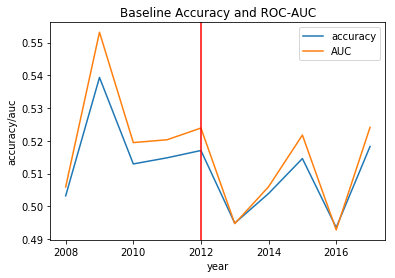

,accuracy,ROC-AUC
2008,0.503222,0.505947
2009,0.539354,0.553145
2010,0.512965,0.519479
2011,0.514837,0.520340
2012,0.517061,0.523916
2013,0.494883,0.494746
2014,0.503941,0.506008
2015,0.514604,0.521766
2016,0.493559,0.492831
2017,0.518282,0.524131


In [66]:
plot_auc_summary(baseline_result, 'Baseline')

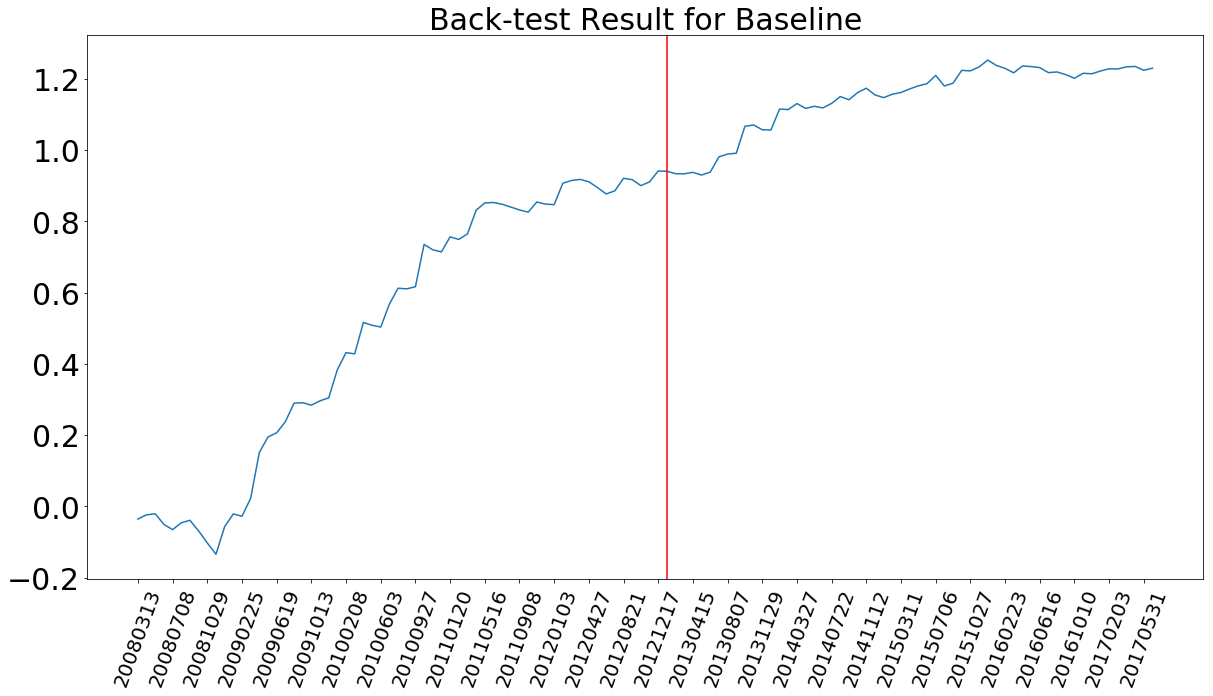

,Return,Sharpe
Year,,
2008,-0.057,-0.692
2009,0.361,3.676
2010,0.409,3.225
2011,0.134,2.118
2012,0.093,1.429
2013,0.115,1.681
2014,0.098,1.818
2015,0.098,2.223
2016,-0.038,-1.367


In [68]:
a3 = back_test(baseline_result, 'Baseline', q=0.90, flag="flag2", ret="ret_20_raw", Alp="Alp")
summary_return_sharpe(a3[2], 12)

## GBDT result

In [69]:
# load gb_result since it's trained before
gb_result = joblib.load('./data/gb_result.pkl')

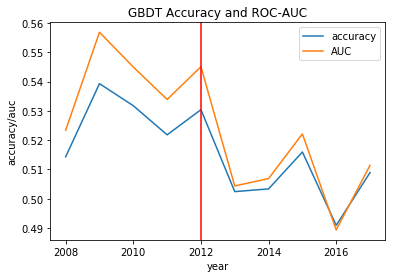

,accuracy,ROC-AUC
2008,0.514320,0.523367
2009,0.539281,0.556830
2010,0.531743,0.544954
2011,0.521804,0.533886
2012,0.530399,0.545056
2013,0.502423,0.504361
2014,0.503349,0.506882
2015,0.515948,0.522128
2016,0.490915,0.489350
2017,0.508923,0.511414


In [70]:
plot_auc_summary(gb_result,'GBDT')

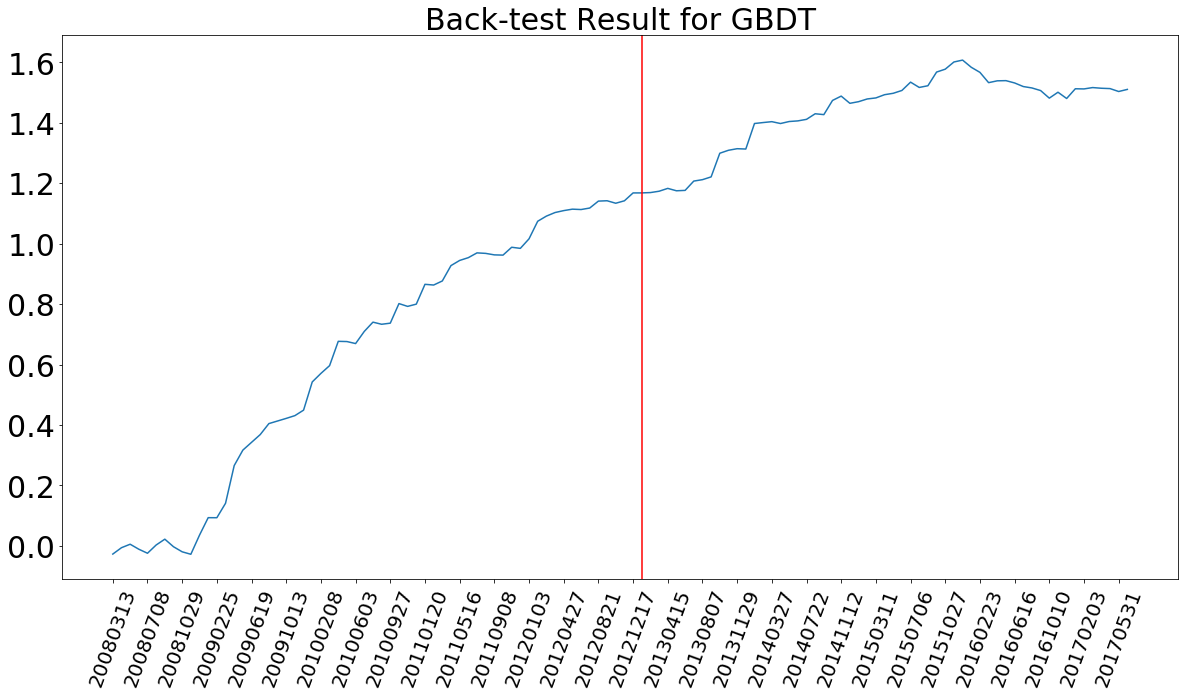

Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,total mean,in mean,out mean
Return,0.036,0.413,0.351,0.184,0.183,0.145,0.151,0.143,-0.127,0.03,0.151,0.234,0.068
Sharpe,0.534,4.637,3.599,3.128,3.711,2.318,2.056,3.416,-3.260,1.47,2.161,3.122,1.200


In [71]:
gb_res = back_test(gb_result, 'GBDT', q=0.90, flag="flag2", ret="ret_20_raw", Alp="Alp")
summary_return_sharpe(gb_res[2], 12).T

## LSTM result

In [72]:
# load lstm_result since it's trained before
lstm_result = pd.read_csv('./data/lstm_result.csv')

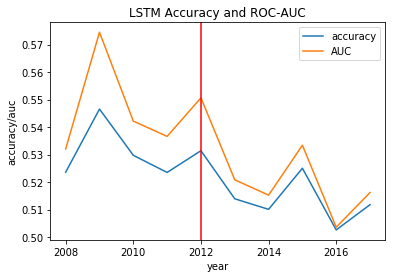

,accuracy,ROC-AUC
2008,0.523600,0.532030
2009,0.546550,0.574474
2010,0.529743,0.542174
2011,0.523516,0.536623
2012,0.531418,0.550638
2013,0.513937,0.520839
2014,0.510101,0.515266
2015,0.525038,0.533398
2016,0.502625,0.503617
2017,0.511804,0.516201


In [73]:
plot_auc_summary(lstm_result,'LSTM')

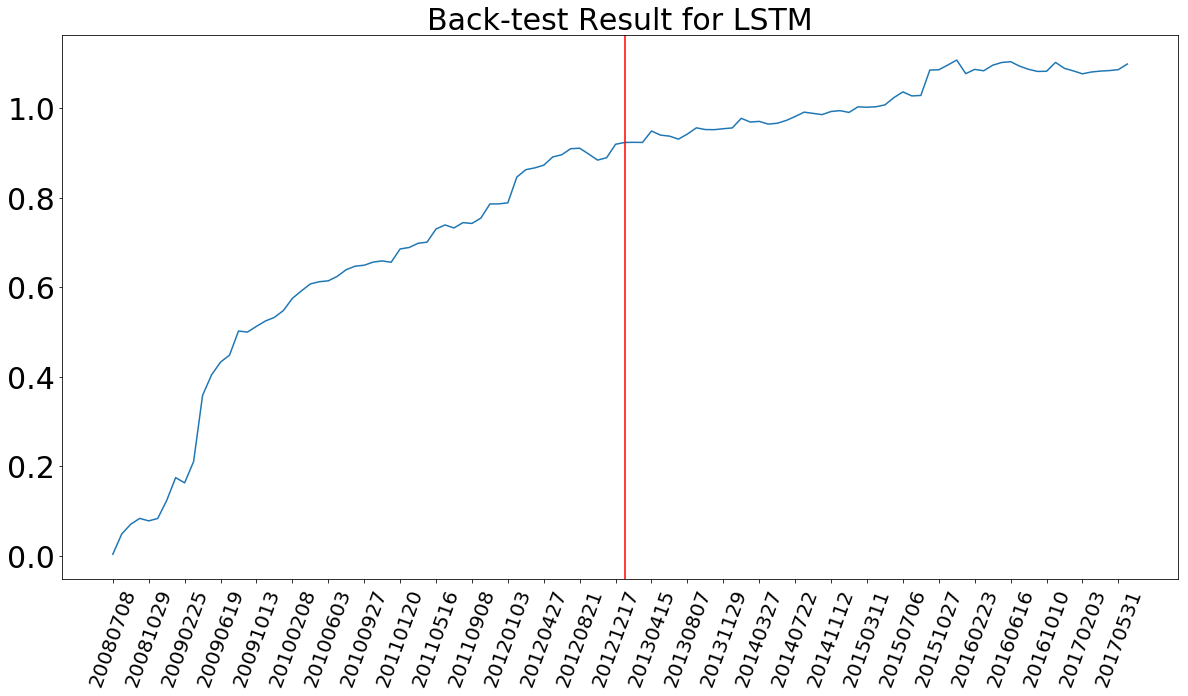

Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,total mean,in mean,out mean
Return,0.123,0.409,0.123,0.131,0.133,0.037,0.039,0.113,-0.019,0.010,0.110,0.184,0.036
Sharpe,4.191,3.723,5.274,3.849,2.537,1.380,1.812,2.450,-0.535,0.996,2.568,3.915,1.221


In [74]:
lstm_res = back_test(lstm_result, 'LSTM', q=0.90, flag="flag2", ret="ret_20_raw", Alp="Alp")
summary_return_sharpe(lstm_res[2], 12).T